In [20]:
#Import necessary libraries and 
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import seaborn as sns 

In [21]:
#Narrow search based on ticker symbol and start and end date of the historical data pull
ticker = 'XEL'
start = '2017-11-17'
end = '2022-11-01'

In [22]:
#Download the stock data based on the variables outlined above
stock_data = yf.download(ticker, start, end, adjusted=True)
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-17,51.060001,51.279999,50.799999,50.889999,44.150799,2185400
2017-11-20,50.919998,51.049999,50.560001,50.590000,43.890522,2176500
2017-11-21,50.730000,50.830002,50.540001,50.610001,43.907875,2740500
2017-11-22,50.610001,50.740002,50.349998,50.529999,43.838467,1928100
2017-11-24,50.669998,50.880001,50.639999,50.709999,43.994625,956000


In [23]:
#Run the Fama French library to pull, Mkt-RF (risk free rate), SMB (performance of small cap stocks relative to large cap) and HML (high book to market value stocks compared to low book to market)
ff_monthly = gff.famaFrench3Factor(frequency='m')
ff_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff_monthly.set_index('Date', inplace=True)
ff_monthly.tail()

,Mkt-RF,SMB,HML,RF
Date,,,,
2022-05-31,-0.0034,-0.0185,0.0841,0.0003
2022-06-30,-0.0843,0.0209,-0.0597,0.0006
2022-07-31,0.0957,0.0281,-0.0410,0.0008
2022-08-31,-0.0378,0.0139,0.0031,0.0019
2022-09-30,-0.0936,-0.0081,0.0005,0.0019


In [24]:
#Looking just at the adjusted close amounts on a per month basis from the Yahoo Finance pull, look at the percent change in comparison to prior month's data, and drop empty data fields
stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = "Month_Rtn"

#Merge stock details with the Fama French details
ff_data = ff_monthly.merge(stock_returns,on='Date')
ff_data.tail()

,Mkt-RF,SMB,HML,RF,Month_Rtn
Date,,,,,
2022-05-31,-0.0034,-0.0185,0.0841,0.0003,0.028392
2022-06-30,-0.0843,0.0209,-0.0597,0.0006,-0.054041
2022-07-31,0.0957,0.0281,-0.0410,0.0008,0.034200
2022-08-31,-0.0378,0.0139,0.0031,0.0019,0.014621
2022-09-30,-0.0936,-0.0081,0.0005,0.0019,-0.132408


In [25]:
#Define variables required to calculate the beta values
X = ff_data[['Mkt-RF', 'SMB', 'HML']]
y = ff_data['Month_Rtn'] - ff_data['RF']
X = sm.add_constant(X)

In [26]:
#Develop a model using the variables defined above
ff_model = sm.OLS(y, X).fit()
print(ff_model.summary())
intercept, b1, b2, b3 = ff_model.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     7.039
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           0.000444
Time:                        19:57:09   Log-Likelihood:                 98.013
No. Observations:                  58   AIC:                            -188.0
Df Residuals:                      54   BIC:                            -179.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.006      0.556      0.5

In [27]:
#Redefine values to help calculate the CAPM value
x_capm = ff_data[['Mkt-RF']]
y_capm = ff_data['Month_Rtn'] - ff_data['RF']
X_capm = sm.add_constant(x_capm)


In [28]:
#Run the CAPM calculation to find the intercept, and corresponding betas
ff_model_capm = sm.OLS(y_capm, X_capm).fit()
print(ff_model_capm.summary())
intercept_capm, b1_capm = ff_model_capm.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     7.997
Date:                Thu, 17 Nov 2022   Prob (F-statistic):            0.00649
Time:                        19:57:10   Log-Likelihood:                 92.312
No. Observations:                  58   AIC:                            -180.6
Df Residuals:                      56   BIC:                            -176.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.007      0.654      0.5

In [29]:
intercept_capm

0.004338959916279076

In [30]:
b1_capm

0.3403347567392534

In [31]:
#Define variables to calculate the expected return using both the CAPM and Fama French
mkt_rf = .61
hml = .38
smb = .25
rf = .33

In [32]:
#Create and run the CAPM expected return calculation using the variables and inputs from above
capm_exreturn = rf + (mkt_rf*b1_capm)
calc_capm_exreturn = (1+(capm_exreturn/100))**12-1
calc_capm_exreturn

0.06645462492257326

In [33]:
# Print results
print(f"Using the CAPM model, our expected rate of return on {ticker} is {round(100*calc_capm_exreturn,2)}%.")

Using the CAPM model, our expected rate of return on XEL is 6.65%.


In [34]:
#Create and run the Fama French expected return calculation using the variables and inputs from above
ff_exreturn = rf + (mkt_rf*b1)+(smb*b2)+(hml*b3)
calc_ff_exreturn = (1+(ff_exreturn/100))**12-1
calc_ff_exreturn

0.054672179822619515

In [35]:
# Print results
print(f"Using the Fama French 3 Factor model, our expected rate of return on {ticker} is {round(100*calc_ff_exreturn,2)}%.")

Using the Fama French 3 Factor model, our expected rate of return on XEL is 5.47%.


<AxesSubplot:xlabel='Mkt-RF', ylabel='Month_Rtn'>

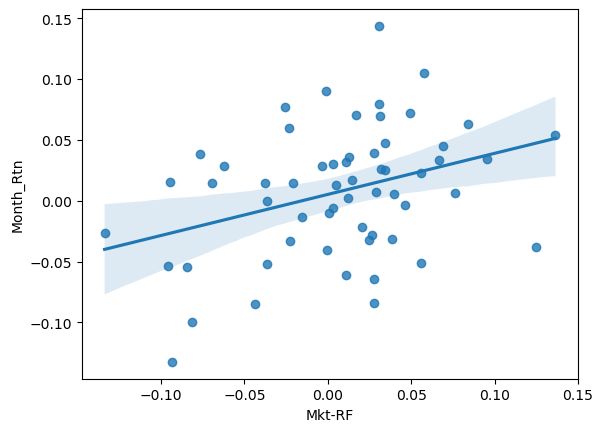

In [41]:
#Display a regression of the market return agains the chosen stock
sns.regplot(data = ff_data, x = 'Mkt-RF', y='Month_Rtn')